# __Final Project: Adding captions to your photos__

__Install__

```sh
pip install kaggle
```

__Download__

```sh
kaggle datasets download -d adityajn105/flickr8k
```

__Extract__

```sh
tar -xf flickr8k.zip
```
```

### __Libraries__

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
import sentencepiece as spm
from torch.nn.utils.rnn import pack_padded_sequence
from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


### __Dataframe Creation__

In [2]:
# Read the captions CSV file into a DataFrame
captions_file = 'captions.txt'
df = pd.read_csv(captions_file)

# Shuffle if desired
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
unique_images = df['image'].unique()

train_images, test_images = train_test_split(unique_images, test_size=0.2, random_state=42)

# Create train and test DataFrames by filtering
train_df = df[df['image'].isin(train_images)].reset_index(drop=True)
test_df = df[df['image'].isin(test_images)].reset_index(drop=True)
df = train_df

In [3]:
df

,image,caption
0,2973269132_252bfd0160.jpg,A large wild cat is pursuing a horse across a ...
1,270263570_3160f360d3.jpg,Two brown dogs fight on the leafy ground .
2,2053006423_6adf69ca67.jpg,A man in shorts is standing on a rock looking ...
3,512101751_05a6d93e19.jpg,a muzzled white dog is running on the grass .
4,3156406419_38fbd52007.jpg,A person skiing downhill .
...,...,...
32355,2220175999_081aa9cce8.jpg,Two big dogs wade in the ocean
32356,2555622234_3e531e4014.jpg,A wet German Shepherd runs along the waves on ...
32357,525887861_4cc7a1beca.jpg,Little girl in pink skateboard .
32358,1204996216_71d7519d9a.jpg,A boy lays on a picnic table bench .


In [4]:
test_df

,image,caption
0,3512033861_a357bb58b6.jpg,a very large group of people standing crowded ...
1,3498997518_c2b16f0a0e.jpg,Football players on a feild the one on the lef...
2,3399798295_a452963365.jpg,Two women with their arms around each other sm...
3,3549006919_3604bc813e.jpg,a man wearing a yellow helmet climbing the sid...
4,2244024374_54d7e88c2b.jpg,Two dogs fight over a stick in a flooded field .
...,...,...
8090,2771424045_1fdf9617eb.jpg,A young woman poses with a man in face paint .
8091,3536561454_e75993d903.jpg,A man skateboards around an orange cone .
8092,3039675864_0b7961844d.jpg,"A street with pigeons , a motorcyclist and a w..."
8093,3413806271_17b7e102aa.jpg,The people in the red parasail are gliding ove...


### __Using Google's sentencepiece library to create (essentially) vocab.itos and vocab.stoi (torchtext had incompatibility issues with torch CUDA installations)__

In [5]:
captions_only = df['caption'].tolist()

# Write them to a text file (one caption per line)
with open('captions_only.txt', 'w', encoding='utf-8') as f:
    for c in captions_only:
        f.write(c.strip() + '\n')

# Now you have vocab.itos and vocab.stoi

In [6]:
spm.SentencePieceTrainer.train(
    input='captions_only.txt',
    model_prefix='m',
    vocab_size=4000,
    character_coverage=0.99,
    model_type='bpe',
    user_defined_symbols=['<pad>', '<start>', '<end>']
)

sp = spm.SentencePieceProcessor()
sp.load('m.model')

True

In [7]:
text = "A child in a pink dress is climbing up a set of stairs in an entry way."
token_ids = sp.encode_as_ids(text.lower())
pieces = sp.encode_as_pieces(text.lower())
print("Token IDs:", token_ids)
print("Subword Pieces:", pieces)

Token IDs: [6, 139, 18, 6, 314, 267, 43, 449, 206, 6, 696, 52, 1034, 18, 162, 1819, 699, 1589, 3992]
Subword Pieces: ['▁a', '▁child', '▁in', '▁a', '▁pink', '▁dress', '▁is', '▁climbing', '▁up', '▁a', '▁set', '▁of', '▁stairs', '▁in', '▁an', '▁ent', 'ry', '▁way', '.']


In [8]:
# stoi
stoi = {}
# itos will be a list of pieces in order
itos = [sp.id_to_piece(i) for i in range(sp.get_piece_size())]

for i, piece in enumerate(itos):
    stoi[piece] = i

In [9]:
stoi

{'<unk>': 0,
 '<s>': 1,
 '</s>': 2,
 '<pad>': 3,
 '<start>': 4,
 '<end>': 5,
 '▁a': 6,
 'in': 7,
 '▁.': 8,
 '▁t': 9,
 'ing': 10,
 '▁s': 11,
 '▁w': 12,
 '▁b': 13,
 'he': 14,
 '▁o': 15,
 '▁A': 16,
 'an': 17,
 '▁in': 18,
 'it': 19,
 're': 20,
 '▁p': 21,
 '▁d': 22,
 'er': 23,
 '▁the': 24,
 'ro': 25,
 '▁c': 26,
 'le': 27,
 'is': 28,
 'ar': 29,
 '▁m': 30,
 '▁do': 31,
 '▁g': 32,
 'nd': 33,
 'la': 34,
 '▁on': 35,
 '▁h': 36,
 'ck': 37,
 '▁f': 38,
 'ir': 39,
 'at': 40,
 'al': 41,
 '▁dog': 42,
 '▁is': 43,
 '▁T': 44,
 'un': 45,
 '▁and': 46,
 '▁r': 47,
 'ith': 48,
 '▁with': 49,
 'lo': 50,
 'ld': 51,
 '▁of': 52,
 '▁st': 53,
 'en': 54,
 '▁man': 55,
 '▁wh': 56,
 'es': 57,
 'id': 58,
 'om': 59,
 'wo': 60,
 'et': 61,
 '▁to': 62,
 '▁bo': 63,
 'all': 64,
 'rou': 65,
 'and': 66,
 'as': 67,
 '▁pla': 68,
 'ear': 69,
 'wn': 70,
 'or': 71,
 '▁play': 72,
 '▁Two': 73,
 'ite': 74,
 'irl': 75,
 '▁l': 76,
 '▁boy': 77,
 'ed': 78,
 '▁girl': 79,
 'her': 80,
 'ut': 81,
 '▁sh': 82,
 'um': 83,
 'ch': 84,
 '▁white': 85,
 

In [10]:
itos

['<unk>',
 '<s>',
 '</s>',
 '<pad>',
 '<start>',
 '<end>',
 '▁a',
 'in',
 '▁.',
 '▁t',
 'ing',
 '▁s',
 '▁w',
 '▁b',
 'he',
 '▁o',
 '▁A',
 'an',
 '▁in',
 'it',
 're',
 '▁p',
 '▁d',
 'er',
 '▁the',
 'ro',
 '▁c',
 'le',
 'is',
 'ar',
 '▁m',
 '▁do',
 '▁g',
 'nd',
 'la',
 '▁on',
 '▁h',
 'ck',
 '▁f',
 'ir',
 'at',
 'al',
 '▁dog',
 '▁is',
 '▁T',
 'un',
 '▁and',
 '▁r',
 'ith',
 '▁with',
 'lo',
 'ld',
 '▁of',
 '▁st',
 'en',
 '▁man',
 '▁wh',
 'es',
 'id',
 'om',
 'wo',
 'et',
 '▁to',
 '▁bo',
 'all',
 'rou',
 'and',
 'as',
 '▁pla',
 'ear',
 'wn',
 'or',
 '▁play',
 '▁Two',
 'ite',
 'irl',
 '▁l',
 '▁boy',
 'ed',
 '▁girl',
 'her',
 'ut',
 '▁sh',
 'um',
 'ch',
 '▁white',
 'on',
 'lack',
 '▁y',
 '▁are',
 '▁wom',
 '▁black',
 'red',
 '▁wat',
 'oun',
 'no',
 'gh',
 'ple',
 '▁run',
 '▁The',
 'ild',
 '▁ch',
 'ers',
 '▁woman',
 'itt',
 '▁at',
 '▁wear',
 'ur',
 '▁th',
 '▁stand',
 'king',
 'irt',
 'ump',
 'ge',
 '▁wearing',
 'ack',
 'ard',
 'ide',
 '▁water',
 'eo',
 'ic',
 'eople',
 'ss',
 'oo',
 '▁red',
 '▁b

In [11]:
pad_id = sp.piece_to_id('<pad>')
start_id = sp.piece_to_id('<start>')
end_id = sp.piece_to_id('<end>')
unk_id = sp.unk_id()  # usually 0 by default

print(f'pad_id: {pad_id}, start_id: {start_id}, end_id: {end_id}, unk_id: {unk_id}')

pad_id: 3, start_id: 4, end_id: 5, unk_id: 0


### __Creating the loaded dataset from the Flickr8k Dataset__

In [12]:
class FlickrDataset(Dataset):
    def __init__(self, df, img_folder, transform=None, max_len=80):
        self.df = df
        self.img_folder = img_folder
        self.transform = transform
        self.max_len = max_len

        # If you want a train/val split, you can filter df here.
        # Here we use entire df for demonstration.
        self.images = self.df['image'].values
        self.captions = self.df['caption'].values

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        caption_text = self.captions[idx]

        # Load image
        img_path = os.path.join(self.img_folder, img_name)
        image = Image.open(img_path).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)

        # Convert caption text to indices
        pieces = sp.encode_as_pieces(caption_text.lower().strip())
        caption_ids = [start_id] + [stoi.get(p, unk_id) for p in pieces] + [end_id]

        # Pad or truncate to max_len
        if len(caption_ids) < self.max_len:
            caption_ids += [pad_id] * (self.max_len - len(caption_ids))
        else:
            caption_ids = caption_ids[:self.max_len]

        length = sum([1 for token in caption_ids if token != pad_id])

        return image, torch.tensor(caption_ids), length
    
# Define a collate_fn to handle variable lengths
def collate_fn(batch):
    # batch: list of (image, caption, length)
    images = [item[0] for item in batch]
    captions = [item[1] for item in batch]
    lengths = [item[2] for item in batch]

    images = torch.stack(images, 0)
    captions = torch.stack(captions, 0)
    lengths = torch.tensor(lengths, dtype=torch.int64)

    return images, captions, lengths

In [13]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225))
])

dataset = FlickrDataset(df, img_folder='Images', transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

### __CNN + LSTM Architecture__

In [14]:
########################################
# ADD THESE NEW LINES OF CODE
########################################
class Attention(nn.Module):
    def __init__(self, feature_dim, hidden_dim):
        super(Attention, self).__init__()
        # Linear layers to transform features and hidden state to a common space
        self.attention_features = nn.Linear(feature_dim, hidden_dim)
        self.attention_hidden = nn.Linear(hidden_dim, hidden_dim)
        self.attention_score = nn.Linear(hidden_dim, 1)

    def forward(self, features, hidden_state):
        """
        features: [batch_size, feature_dim]
        hidden_state: [batch_size, hidden_size] or None

        We will:
        - If hidden_state is None, use a zero vector of correct shape.
        - Compute a score for how well features align with hidden_state.
        - Since there's only one feature vector per image, attention weight = 1.
        """

        batch_size = features.size(0)

        # If hidden_state is None, create a zero vector
        if hidden_state is None:
            # Assume hidden_dim is the size used in decoder LSTM hidden state
            hidden_dim = self.attention_hidden.in_features
            hidden_state = features.new_zeros((batch_size, hidden_dim))

        # Transform features and hidden_state
        # features_trans: [batch_size, hidden_dim]
        # hidden_trans: [batch_size, hidden_dim]
        features_trans = self.attention_features(features)
        hidden_trans = self.attention_hidden(hidden_state)

        # Combine and apply tanh
        combined = torch.tanh(features_trans + hidden_trans)  # [batch_size, hidden_dim]

        # Compute raw attention scores: [batch_size, 1]
        scores = self.attention_score(combined)

        # Since we have only one vector, softmax over one element is always 1
        alpha = torch.softmax(scores, dim=1)  # [batch_size, 1] = 1

        # Weighted sum of features with alpha
        context = features * alpha  # same as features since alpha=1
        return context
########################################

class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet152(pretrained=True)
        # remove the last fc layer
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)

    def forward(self, images):
        with torch.no_grad():
            features = self.resnet(images)
        features = features.reshape(features.size(0), -1)
        features = self.bn(self.linear(features))
        return features

class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1, max_seq_length=80, itos=None):
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size, padding_idx=pad_id)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seq_length = max_seq_length
        self.itos = itos

        ########################################
        # ADD THIS NEW LINE TO INSTANTIATE ATTENTION
        ########################################
        self.attention = Attention(embed_size, hidden_size)

    def forward(self, features, captions, lengths):
        # captions include <start>, ..., <end>
        # lengths is count of all non-pad tokens in captions
        embeddings = self.embed(captions)

        ########################################
        # ADD THESE NEW LINES TO USE ATTENTION
        ########################################
        # Compute a dummy attention context (just returns features)
        # In a real scenario, you'd also use the LSTM hidden state.
        # For simplicity, we just pass features and a dummy hidden_state (None) to attention.
        context = self.attention(features, None)  # returns features as-is
        ########################################

        embeddings = torch.cat((context.unsqueeze(1), embeddings), 1)
        
        # Use lengths as is
        packed = pack_padded_sequence(embeddings, lengths.cpu(), batch_first=True, enforce_sorted=False)
        outputs, _ = self.lstm(packed)
        outputs = self.linear(outputs[0])
        return outputs
    
    def predict(self, features, states=None):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []
        ########################################
        # ADD NEW LINE TO APPLY ATTENTION DURING PREDICT
        # Just like in forward, we use attention on features
        ########################################
        context = self.attention(features, None)
        inputs = context.unsqueeze(1)

        for i in range(self.max_seq_length):
            hiddens, states = self.lstm(inputs, states)
            outputs = self.linear(hiddens.squeeze(1))
            _, predicted = outputs.max(1)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted).unsqueeze(1)

        sampled_ids = torch.stack(sampled_ids, 1)

        # Convert word_ids to words using itos
        sentences = []
        for sample_id in sampled_ids:
            sample_id = sample_id.cpu().numpy()
            sampled_caption = []
            for word_id in sample_id:
                word = self.itos[word_id]
                if word == '<end>':
                    break
                if word not in ['<start>', '<pad>', '<end>']:
                    sampled_caption.append(word)
            # Join the subwords or decode with SentencePiece if desired
            sentence = ''.join(sampled_caption).replace('▁', ' ').strip()
            sentences.append(sentence)
        return sentences

### __Training__

In [15]:
embed_size = 256
hidden_size = 512
num_layers = 1
learning_rate = 0.001
num_epochs = 30

encoder = EncoderCNN(embed_size=embed_size).to(device)
decoder = DecoderRNN(embed_size=embed_size, hidden_size=hidden_size, vocab_size=len(itos), num_layers=num_layers, itos=itos).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=pad_id)
params = list(decoder.parameters()) + list(encoder.linear.parameters()) + list(encoder.bn.parameters())
optimizer = torch.optim.Adam(params, lr=learning_rate)

for epoch in range(num_epochs):
    for i, (images, captions, lengths) in enumerate(dataloader):
        images = images.to(device)
        captions = captions.to(device)
        lengths = lengths.to(device)

        # Forward pass
        features = encoder(images)
        outputs = decoder(features, captions, lengths)

        # Because we used pack_padded_sequence, outputs is already the right shape
        # But we need to adjust the target as well (exclude the feature timestep)
        targets = pack_padded_sequence(captions[:, 1:], lengths.cpu(), batch_first=True, enforce_sorted=False)[0]

        loss = criterion(outputs, targets)

        # Backprop and optimize
        decoder.zero_grad()
        encoder.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i}], Loss: {loss.item():.4f}")

print("Training completed.")

c:\Users\yashh\Downloads\aipi-590-project4\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\yashh\Downloads\aipi-590-project4\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/30], Step [0], Loss: 8.2968
Epoch [1/30], Step [100], Loss: 4.8799
Epoch [1/30], Step [200], Loss: 4.5962
Epoch [1/30], Step [300], Loss: 4.4425
Epoch [1/30], Step [400], Loss: 4.2816
Epoch [1/30], Step [500], Loss: 4.1761
Epoch [1/30], Step [600], Loss: 4.0117
Epoch [1/30], Step [700], Loss: 3.6842
Epoch [1/30], Step [800], Loss: 4.0498
Epoch [1/30], Step [900], Loss: 4.1188
Epoch [1/30], Step [1000], Loss: 3.4491
Epoch [2/30], Step [0], Loss: 3.7962
Epoch [2/30], Step [100], Loss: 3.7746
Epoch [2/30], Step [200], Loss: 3.8038
Epoch [2/30], Step [300], Loss: 3.8077
Epoch [2/30], Step [400], Loss: 3.7990
Epoch [2/30], Step [500], Loss: 3.8153
Epoch [2/30], Step [600], Loss: 3.8097
Epoch [2/30], Step [700], Loss: 3.7781
Epoch [2/30], Step [800], Loss: 3.5709
Epoch [2/30], Step [900], Loss: 3.3476
Epoch [2/30], Step [1000], Loss: 3.3961
Epoch [3/30], Step [0], Loss: 3.1770
Epoch [3/30], Step [100], Loss: 3.2431
Epoch [3/30], Step [200], Loss: 3.0406
Epoch [3/30], Step [300], Los

### __Example Caption!__

Image: 1234817607_924893f6e1.jpg
Predicted Caption: a man a yellow stands the . hisved smiling .
Reference Captions: ['a Korean man sells soda .', 'An elderly man is smiling while sitting in front of a row of soda cans .', 'A man wearing glasses with aluminum cans lined up in front of him .', 'Vendor selling drinks in a stall .', 'A man is sitting at an outside bar near many soda and beer cans .']
-------------------------------------------


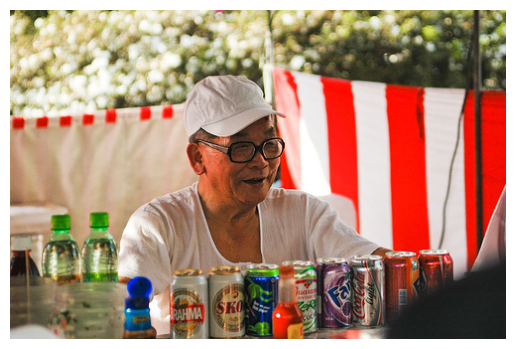

Image: 3472270112_0a7cb7b27c.jpg
Predicted Caption: a boy a in on with on left theoo
Reference Captions: ['A baseman and a ballplayer from the opposing team sliding onto base .', 'Three baseball players in motion ; one sliding into a base , another running in the background .', 'A runner slides into second base while the shortstop waits for the ball', 'Three men playing baseball and the one wearing a red helmet is sliding to the plate .', 'Men participate in a baseball game .']
-------------------------------------------


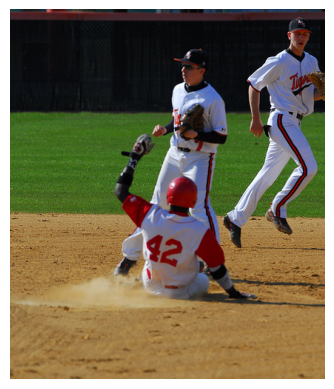

Image: 3464871350_3f2d624a9c.jpg
Predicted Caption: a motorcycle its . while pushes crowd .
Reference Captions: ['Race car driver getting ready for the start of the race .', 'A driver is sitting in a Team Penske race car .', 'A race car driver with an orange helmet sits in a team Penske Indy car at the raceway .', 'A race car sits in the pits .', 'Racing car marked TEAM PENSKE on track , banners and spectators in background .']
-------------------------------------------


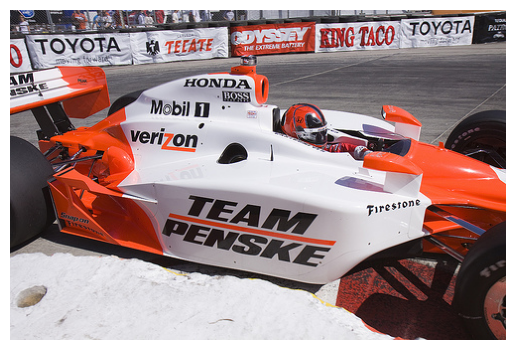

Image: 3043501068_be58ac47e1.jpg
Predicted Caption: a man a bike .<unk> . it shot it
Reference Captions: ['The motocross bike is doing a jump in the air in front of the crowd .', 'A motocross rider doing a jump in front of an audience .', 'A dirt biker is airborne in front of a crowd .', 'The motocross rider does a trick in the air .', 'Man on a motorcycle performing a trick high in the air .']
-------------------------------------------


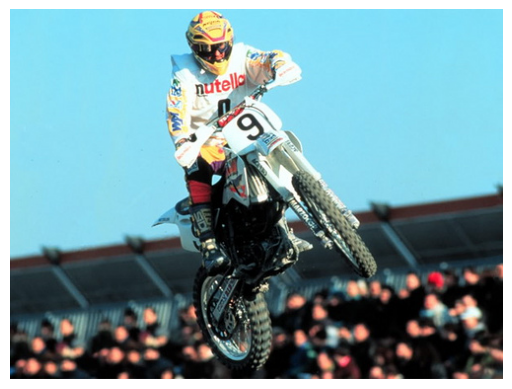

Image: 2045562030_654ddea5e5.jpg
Predicted Caption: a of wearing andm it their is to back
Reference Captions: ['two girls with pink streaked hair and two boys with black hair standing next to a concrete building .', 'A group of teenagers talk next to a building with sandy columns .', 'A group of teenagers talk near a cement wall .', 'Two young girls with dyed hair talk to two boys in black .', 'A group of teenagers , one with pink hair .']
-------------------------------------------


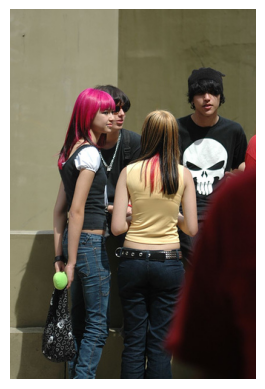

In [16]:
# Ensure models are in evaluation mode
encoder.eval()
decoder.eval()

# Sample 5 random images from the test dataframe
sample_images = test_df['image'].drop_duplicates().sample(n=5)

for img_name in sample_images:
    # Load and preprocess the image
    img_path = os.path.join('Images', img_name)
    image = Image.open(img_path).convert('RGB')
    original_image = image.copy()  # Keep a copy to display
    
    # Apply the same transforms as in training
    image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        # Extract features and generate caption
        features = encoder(image)
        caption = decoder.predict(features)  # returns a list of captions
        predicted_caption = caption[0]

    # Get reference captions from the dataframe
    refs = test_df[test_df['image'] == img_name]['caption'].tolist()

    # Print image name, predicted caption, and references
    print("Image:", img_name)
    print("Predicted Caption:", predicted_caption)
    print("Reference Captions:", refs)
    print("-------------------------------------------")

    # Display the image
    plt.imshow(original_image)
    plt.axis('off')
    plt.show()

Image: IMG_7256.JPG
Predicted Caption: the of approaches areed  facet<unk>iedmc . a    . .<unk>
-------------------------------------------


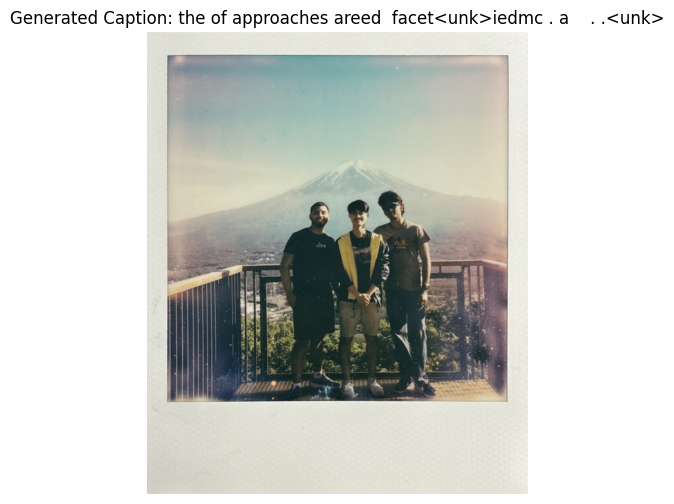

Image: IMG_7605.JPG
Predicted Caption: young boys and ecited for picture
-------------------------------------------


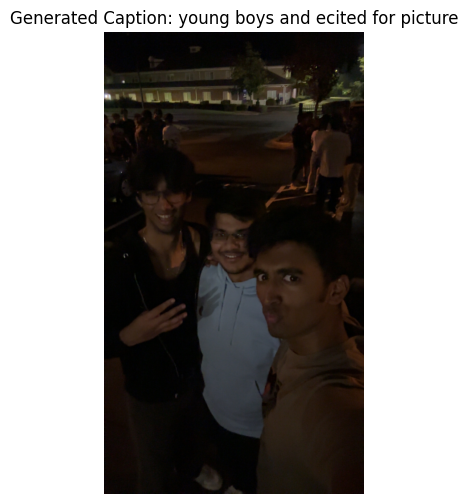

Image: IMG_8162.jpg
Predicted Caption: a is by music in of .
-------------------------------------------


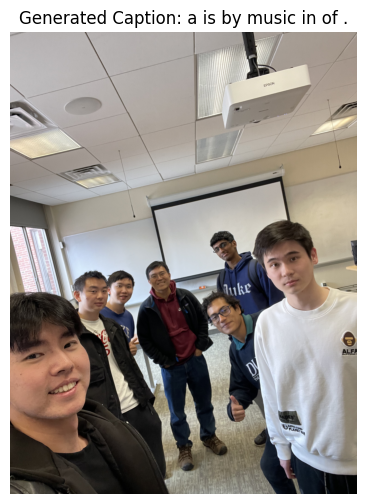

In [17]:
# Path to the folder containing 5 images
folder_path = 'my_imgs'

supported_extensions = ('.png', '.jpg', '.JPG', '.jpeg', '.bmp', '.gif')
image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(supported_extensions)]

for img_name in image_files:
    # Load and preprocess the image
    img_path = os.path.join(folder_path, img_name)
    try:
        image = Image.open(img_path).convert('RGB')
    except Exception as e:
        print(f"Error loading image {img_name}: {e}")
        continue
    original_image = image.copy()  # Keep a copy for display

    # Apply the same transforms as in training
    image = transform(image).unsqueeze(0).to(device)  # Shape: [1, 3, 224, 224]

    with torch.no_grad():
        # Extract features from the encoder
        features = encoder(image)  # Shape depends on EncoderCNN implementation

        # Generate caption using the decoder's predict method
        caption = decoder.predict(features)  # Returns a list of captions
        predicted_caption = caption[0] if caption else "No caption generated."

    # Print image name and predicted caption
    print(f"Image: {img_name}")
    print(f"Predicted Caption: {predicted_caption}")

    # Optional: If you have reference captions in test_df, print them
    # Uncomment the following block if using a DataFrame with reference captions
    """
    if img_name in test_df['image'].values:
        refs = test_df[test_df['image'] == img_name]['caption'].tolist()
        print(f"Reference Captions: {refs}")
    else:
        print("Reference Captions: N/A")
    """

    print("-------------------------------------------")

    # Display the image
    plt.figure(figsize=(6,6))
    plt.imshow(original_image)
    plt.axis('off')
    plt.title(f"Generated Caption: {predicted_caption}")
    plt.show()


### __BLEU Score & Analyzing Overfitting__

In [18]:
chencherry = SmoothingFunction()

def evaluate_bleu(encoder, decoder, df, transform, device, split_name="data"):
    references_list = []
    predictions_list = []
    images = df['image'].unique()

    encoder.eval()
    decoder.eval()

    for img_name in images:
        # Get all ground truth (reference) captions for this image
        ref_caps = df[df['image'] == img_name]['caption'].tolist()
        # Tokenize references
        ref_tokens = [c.lower().split() for c in ref_caps]

        # Load and preprocess the image
        img_path = os.path.join('Images', img_name)
        image = Image.open(img_path).convert('RGB')
        image = transform(image).unsqueeze(0).to(device)

        with torch.no_grad():
            features = encoder(image)

        predicted_captions = decoder.predict(features)
        predicted_caption = predicted_captions[0]

        # Tokenize the predicted caption
        candidate_tokens = predicted_caption.lower().split()

        references_list.append(ref_tokens)
        predictions_list.append(candidate_tokens)

    # Apply smoothing function for BLEU calculation
    bleu_score = corpus_bleu(
        references_list, 
        predictions_list, 
        smoothing_function=chencherry.method1
    )
    print(f"{split_name} Corpus BLEU score:", bleu_score)
    return bleu_score

# After you have re-trained for more epochs and reloaded the best model:
test_bleu = evaluate_bleu(encoder, decoder, test_df, transform, device, split_name="Test")

# If you have a train_df
train_bleu = evaluate_bleu(encoder, decoder, df, transform, device, split_name="Train")

# Compare BLEU scores to assess overfitting
print("Difference (Train BLEU - Test BLEU):", train_bleu - test_bleu)

Test Corpus BLEU score: 0.0030308793316313914
Train Corpus BLEU score: 0.005861051200687621
Difference (Train BLEU - Test BLEU): 0.0028301718690562296


__Since transformer-based image captioning is far more computational and time intensive on my GPU, I have decided not to do the comparison. (resources are not permitted)__